## Author name:

<pre> Babak Ansari-Jaberi</pre>
<pre> November 2018</pre>

# User Story points(weight) prediction

The grid search may take long time to train so it probably is better to try the example on local running jupyter notebook

### Data Prepration

Load data from development tracking software and prepare it for machine learning.

The data would include the work item number, the previously predicted weight and columns of required activities (called labels) to be used for training.

In [109]:
# The needed liberaries
# !pip install sklearn
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install xlrd 
# !pip3 install nltk

In [110]:
import os

# This is for intelisense
%config IPCompleter.greedy=True

# Supress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [111]:

import getpass
import pandas as pd
import numpy as np
import os.path
from pandas import ExcelWriter
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle


file_name = 'Team1JiraReportMain.xlsx'
jiraFileExist = os.path.exists(file_name)

The `Team1JiraReportMain.xlsx` file has the issue number and the Labels assigned by scrum team. It is actual data from a practical experiment. The data is extracted from the issue tracking software using provided APIs.


In [112]:
# Read data from existing User Story prediction file
print("Data loaded from file:",file_name)
df = pd.read_excel(file_name)
print(df.shape)
df.head()

Data loaded from file: Team1JiraReportMain.xlsx
(90, 31)


,Unnamed: 0,Index,Key,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Communication,ML-L-Configuration,ML-L-Studying,ML-L-Test-Automation,...,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,Points,Summary
0,8,0,ILX-13044,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,Logout from V6 or ACTS does not actually logou...
1,14,1,ILX-11815,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,Some of the Alliance admin users are not able ...
2,17,2,ILX-11017,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,2,DataCollector is not working for PROD sites
3,20,3,ILX-11877,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,Deleting an object inherited from abstract obj...
4,29,4,ILX-14406,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,2,Colas - Create an SQL Script which will extend...


In [117]:
df.describe()

,Unnamed: 0,Index,ML-L-Code-Automation,ML-L-Code-Business,ML-L-Code-UI,ML-L-Communication,ML-L-Configuration,ML-L-Studying,ML-L-Test-Automation,ML-L-Test-Manual,...,ML-S-Code-Automation,ML-S-Code-Business,ML-S-Code-Script,ML-S-Code-UI,ML-S-Communication,ML-S-Configuration,ML-S-Studying,ML-S-Test-Automation,ML-S-Test-Manual,Points
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,148.622222,44.500000,0.033333,0.111111,0.011111,0.011111,0.011111,0.044444,0.055556,0.022222,...,0.033333,0.188889,0.022222,0.166667,0.055556,0.055556,0.055556,0.088889,0.211111,3.800000
std,80.693007,26.124701,0.180511,0.316030,0.105409,0.105409,0.105409,0.207235,0.230345,0.148231,...,0.180511,0.393613,0.148231,0.374766,0.230345,0.230345,0.230345,0.286178,0.410383,1.995501
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,78.750000,22.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,147.000000,44.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,219.500000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,290.000000,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


### Training 

Divide data into 70% for training and 40% for testing:

In [118]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

54 train + 36 test


Identify target column and feature variables:

In [119]:
target = 'Points'
features = list(train_set.columns)
features = [f for f in features if f!=target and f!='Index' and f!='Key' and f!='Summary']

# Split data into train and test sets
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [120]:
# Encode points using one hot encoder
from sklearn.preprocessing import OneHotEncoder

points_tr = train_set[[target]]

cat_encoder = OneHotEncoder(sparse=False)

points_tr_fit = cat_encoder.fit(points_tr)

points_tr_cat = points_tr_fit.transform(points_tr)

points_te = test_set[[target]]
points_te_cat = cat_encoder.fit_transform(points_te)

points_te_cat
y_tr = points_tr_cat
y_te = points_te_cat


Define training model liberaries and a function for finding best parameters for a model using for Grid Search:

In [121]:
import pandas

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from nltk.classify.scikitlearn import SklearnClassifier

pd.options.mode.chained_assignment = None 

def SearchBestParameters(model, parameters):
    y = df[[target]]
    #yy = label_binarize(y, classes=[0, 1, 2 , 3, 4])
    yy = label_binarize(y, classes=[1, 2, 3 , 5, 8])
    n_classes = yy.shape[1]
    classifier = OneVsRestClassifier(model)

    #gs = GridSearchCV(classifier, parameters, cv=5, scoring='r2') # Using R^2 (coefficient of determination)
    gs = GridSearchCV(classifier, parameters, cv=5) # Using R^2 (coefficient of determination)
    gs.fit(X_tr, y_tr).decision_function(X_te)    
    
    #print(classifier.get_params().keys())
    model_params = {}
    for param in gs.best_params_:
        model_param = param.replace("estimator__", "")
        model_params[model_param] = gs.best_params_[param]
    print(type(model).__name__, ': ', model_params, 'with score:', gs.best_score_)
    return model_params

Using Grid Search to find the best parameters for `Logistic Regression` classifier:

In [122]:
grid = {
    'estimator__C': [0.01, 1, 5, 7],
    'estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'estimator__multi_class': ['ovr', 'multinomial']
}
logistic = LogisticRegression()
best_params = SearchBestParameters(logistic, grid)
logistic = LogisticRegression(**best_params)   
    

LogisticRegression :  {'C': 1, 'multi_class': 'multinomial', 'solver': 'lbfgs'} with score: 0.4444444444444444


Using Grid Search to find the best parameters for `SVC` classifier:

In [123]:
grid={
    'estimator__C': [0.5, 1, 5, 7],
    'estimator__kernel': [ 'linear', 'poly', 'rbf']
}
svc = SVC(probability=True)
best_params = SearchBestParameters(svc, grid)
svc = SVC(probability=True, **best_params)

SVC :  {'C': 0.5, 'kernel': 'linear'} with score: 0.4074074074074074


In [124]:
grid={
    'estimator__C': [3, 5, 7],
    'estimator__multi_class': ['ovr', 'crammer_singer'], 
}
linearSVC = LinearSVC()
best_params = SearchBestParameters(linearSVC, grid)
linearSVC = LinearSVC(**best_params)

LinearSVC :  {'C': 3, 'multi_class': 'crammer_singer'} with score: 0.4074074074074074


Add all models to ensemble and one of good one to Ada Boost classifier:

In [126]:
def create_fibonacci_numbers(size):
    fibonacci_numbers = [1, 1]
    for i in range(2,size):
        fibonacci_numbers.append((fibonacci_numbers[i-1]+fibonacci_numbers[i-2]))

    #fibonacci_numbers[0] = 0
    fibonacci_numbers = np.delete(fibonacci_numbers, 0)

    np.array(map(str, fibonacci_numbers))
    fibonacci_numbers = np.array(fibonacci_numbers)
    return fibonacci_numbers

create_fibonacci_numbers(8)
adaBoost = AdaBoostClassifier(logistic)  

Create `score_model` function to draw the classifiers performance:

In [127]:
def one_hot_decode(coded):         
    decoded = coded.dot(cat_encoder.active_features_).astype(int)
    return decoded

def display_scores(scores):
    print("\033[1mCross Validation Score:\033[0m \n\t{} (+/- {})".format(round(scores.mean(),2), round(scores.std(),2)))


In [130]:
def F(n):
    if n == 0: return 0
    elif n == 1: return 1
    else: return F(n-1)+F(n-2)
    
def score_model(model): 
    print('<< \033[1m', type(model).__name__, '\033[0m>>')
    # Binarize the output
    y = df[[target]]
    #classes=[0, 1, 2 , 3, 4]
    classes=[1, 2, 3 , 5, 8]
    yy = label_binarize(y, classes=classes)
    n_classes = yy.shape[1]

    classifier = OneVsRestClassifier(model)
    
    y_score = classifier.fit(X_tr, y_tr).decision_function(X_te) 
    # plot the roc curve
    if hasattr(model, 'predict_proba'):
        # Binarize the output
        lw=2
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i], pos_label=1)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score.ravel(), pos_label=1)
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(F(i+2), roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid()
        plt.xticks(np.arange(0,1.1,0.1))
        plt.yticks(np.arange(0,1.1,0.1))
        plt.show()

    # Test vs prediction scatter plot
    y_score_c = classifier.predict(X_te)

    decoded_y_te = one_hot_decode(y_te)
    decoded_y_score_c = one_hot_decode(y_score_c)
    
    #print(decoded_y_te.shape)
    #print(decoded_y_score_c.shape)
    
    cm = confusion_matrix(decoded_y_te, decoded_y_score_c)
        
    df_cm = pd.DataFrame(cm)
    xy_lbl = create_fibonacci_numbers(cm.shape[0]+1)    
    df_cm.columns = xy_lbl
    df_cm = df_cm.set_index(xy_lbl)
    
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True)
    plt.show()

    # Test and prediction distribution plot
    sns.distplot( decoded_y_te )
    sns.distplot( decoded_y_score_c )
    plt.show()
        
    # Prediction Score
    print('\033[1mEstimator Score:\033[0m\n\tTraining: ', round(classifier.score(X_tr, y_tr), 2), 
            '\n\tTest : ', round(classifier.score(X_te, y_te),2))

    scores = cross_val_score(classifier, X_tr, y_tr,scoring="accuracy", cv=5)

    display_scores(scores)
    print('_______________________________________________________________________')
    return df_cm

Using `score_model` to plot the models accuracy:

<<  LogisticRegression >>


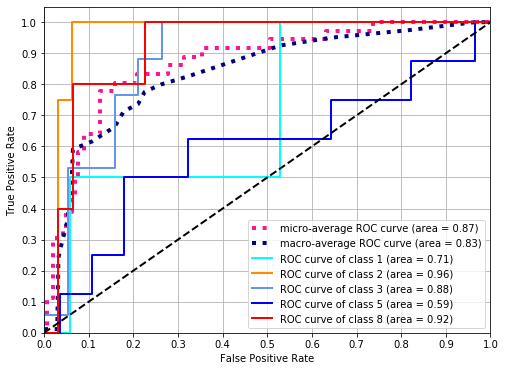

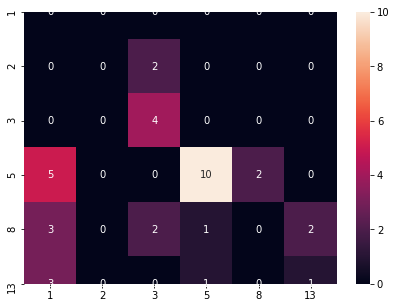

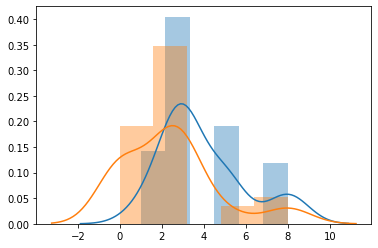

Estimator Score:
	Training:  0.7 
	Test :  0.42
Cross Validation Score: 
	0.45 (+/- 0.12)
_______________________________________________________________________
<<  SVC >>


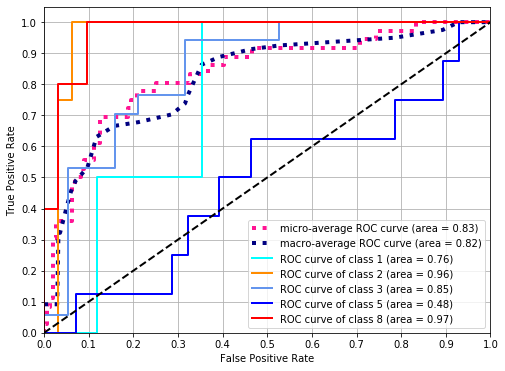

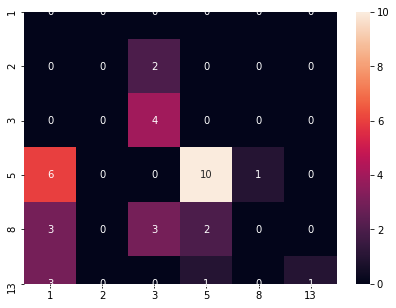

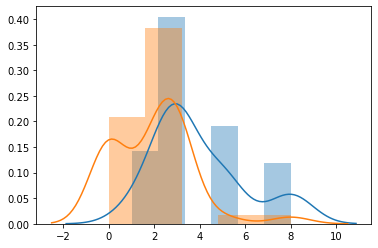

Estimator Score:
	Training:  0.65 
	Test :  0.42
Cross Validation Score: 
	0.41 (+/- 0.2)
_______________________________________________________________________
<<  AdaBoostClassifier >>


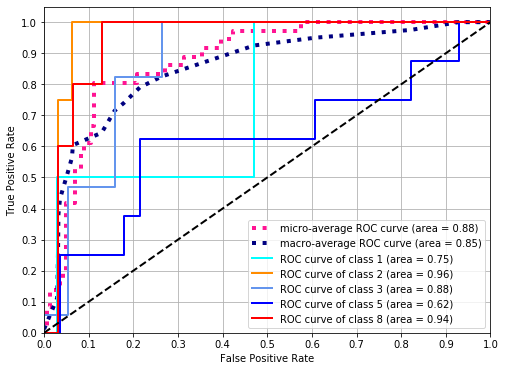

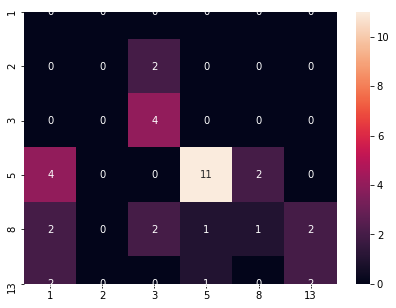

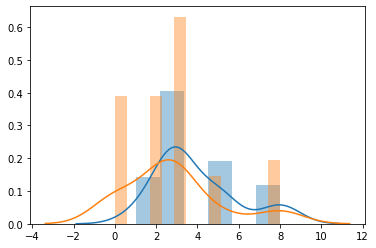

Estimator Score:
	Training:  0.7 
	Test :  0.5
Cross Validation Score: 
	0.45 (+/- 0.12)
_______________________________________________________________________
<<  LinearSVC >>


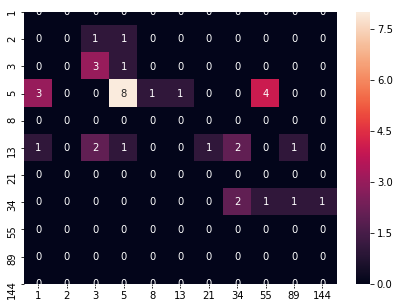

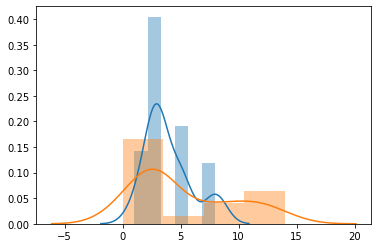

Estimator Score:
	Training:  0.8 
	Test :  0.36
Cross Validation Score: 
	0.28 (+/- 0.15)
_______________________________________________________________________


,1,2,3,5,8,13,21,34,55,89,144
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0
3,0,0,3,1,0,0,0,0,0,0,0
5,3,0,0,8,1,1,0,0,4,0,0
8,0,0,0,0,0,0,0,0,0,0,0
13,1,0,2,1,0,0,1,2,0,1,0
21,0,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,2,1,1,1
55,0,0,0,0,0,0,0,0,0,0,0
89,0,0,0,0,0,0,0,0,0,0,0


In [131]:
score_model(logistic)
score_model(svc)
score_model(adaBoost)
score_model(linearSVC)

### Prediction

Get the User Story number and predict its size base on the given `Labels`:

In [132]:
prediction_df = df.copy()
prediction_df = prediction_df.drop(columns=['Index', 'Key', 'Points', 'Summary']).iloc[0:0]
prediction_df.shape

(0, 27)

The following code explains how to connect to Jira issue tracking system to fetch a User Story that is labeled and predict its points based on the labels:

In [139]:
userName = 'user1@company.com' 
password = getpass.getpass(prompt='Username: '+userName+'\r\nPassword: ')

auth_jira = JIRA(server = 'https://company.atlassian.net', auth=( userName, password ))

#story = input( "User Story # ILX-")
#story = '8397'  original estimated points 3pts    
#story = '10559' original estimated points 2pts
#story = '9885'  original estimated points 8pts

issue = auth_jira.issue('ILX-'+story)
print('Predicting points for \033[1m\033[94m`',issue.fields.summary ,'`\033[0m User Story.')

Prepare the input data for prediction:

In [140]:
for column in prediction_df.columns:
    prediction_df.loc[0, column] = 0
    for label in issue.fields.labels:
        prediction_df.loc[0, label] = 1

print('Manual prediction was:\033[1m\033[94m', issue.fields.customfield_10049,'\033[0m')


Create predict points function to use various models for prediction:

In [135]:
import operator

def predict_points(model, input_df): 
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_tr, y_tr)
    predict = classifier.predict(prediction_df)
    if hasattr(model, 'predict_proba'):
        predict_prop = classifier.predict_proba(prediction_df)
        prediction = one_hot_decode(predict[0])
        index, value = max(enumerate(predict_prop[0]), key=operator.itemgetter(1))
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            F(index+2), '\033[0mpoints with\033[1m\033[94m', round(value,2)*100,'%\033[0m probability')
    else:
        prediction = one_hot_decode(predict[0])
        print('\033[1m',type(model).__name__, '\033[0mprediction is\033[1m\033[94m', 
            prediction, '\033[0mpoints')


Predict using various prediction models:

In [0]:
predict_points(logistic, prediction_df)
predict_points(svc, prediction_df)
predict_points(linearSVC, prediction_df)
predict_points(adaBoost, prediction_df)


 LogisticRegression prediction is 3 points with 43.0 % probability
 SVC prediction is 3 points with 36.0 % probability
 LinearSVC prediction is 0 points
 AdaBoostClassifier prediction is 3 points with 50.0 % probability


### Conclusion

 - VotingClassifier, GaussianNB and SVC seems to perform very well
 - The data is not well defined and dimension could be reduced
 - There could be weightage for each Label to make prediction more accurate
 - Not enough data defined